## Laborator 4 Versiune Imbunatatita

## Obiective

* familiaziraze cu tensorflow slim.
* modificarea unei retele neurale in slim
* vizualizare date input
* vizualizare activari
* tf.metrics


## Pasul 0. Upload dependinte Python#

* cifar10.py
* download.py
* dataset.py
* cache.py


In [1]:

from google.colab import files
uploaded = files.upload()
print("OK")

Saving download.py to download (7).py
Saving dataset.py to dataset (8).py
Saving cifar10.py to cifar10 (7).py
Saving cache.py to cache (7).py
OK


In [0]:
# verificam ca totul este ok
!ls .

cache (1).py  cifar10 (1).py  ckpts	      dataset (4).py   download (3).py
cache (2).py  cifar10 (2).py  data	      dataset (5).py   download (4).py
cache (3).py  cifar10 (3).py  datalab	      dataset (6).py   download (5).py
cache (4).py  cifar10 (4).py  dataset (1).py  dataset.py       download.py
cache (5).py  cifar10 (5).py  dataset (2).py  download (1).py  __pycache__
cache.py      cifar10.py      dataset (3).py  download (2).py


## Pasul 1. Incarcarea dataset-ului

In [0]:
import cifar10


In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [4]:
!ls data/CIFAR-10

cifar-10-batches-py  cifar-10-python.tar.gz


## Pasul 2. Inspecatarea dataset-ului. Histograma + Imagini sample

In [5]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [7]:
import numpy as np

print(images_train.shape)
print(images_test.shape)

# one hot encodings
print(labels_train.shape)
print(labels_test.shape)

# class labels
print(cls_train.shape)
print(cls_test.shape)


print("Train count {}".format(images_train.shape[0]))
print("Test count {}".format(images_test.shape[0]))

cls_ids = np.unique(cls_train)
print("Class labels {}.".format(cls_ids))

n_classes = len(cls_ids)
print("Num classes {}".format(n_classes))





(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)
(50000,)
(10000,)
Train count 50000
Test count 10000
Class labels [0 1 2 3 4 5 6 7 8 9].
Num classes 10


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [0]:
# check data statistics

def get_stats(labels):
    stats = np.zeros(n_classes)
    for e in labels:
        stats[e] += 1
    return stats
  
# bar_width = 0.
def plot_stats(stats, title):
    plt.figure()
    x = range(n_classes)
    plt.title(title)
    plt.bar(x, stats)

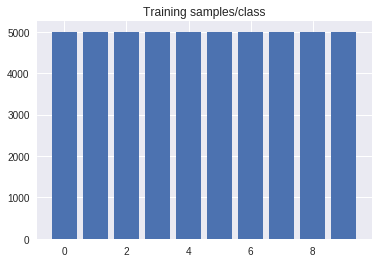

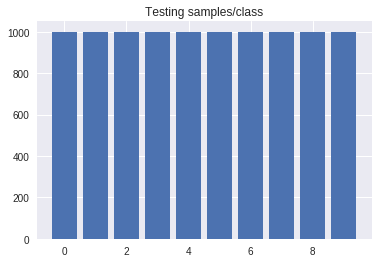

In [10]:
y_train = cls_train
y_test = cls_test

X_train = images_train
X_test = images_test

train_stats = get_stats(y_train)
test_stats = get_stats(y_test)

plt.figure()
plot_stats(train_stats, "Training samples/class")
plot_stats(test_stats, "Testing samples/class")

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

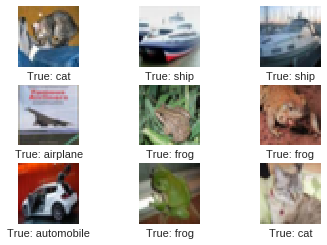

In [12]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

### Vizualizati dataset-ul cu sample-uri din fiecare clasa.

In [13]:
num_samples = 10

image_shape = images_train.shape[1:]

img_height, img_width = image_shape[0], image_shape[1]

print("hxw {}x{}".format(img_height, img_width))

def draw_samples(X, y, y_target, num_cl, colormap = None):
    c_ids = np.where(y == y_target)
    selected_idx = random.sample(c_ids[0].tolist(), num_samples)
    for i, idx in enumerate(selected_idx):
        plt.subplot(num_cl, num_samples, (num_samples * y_target) + i + 1)
        plt.axis('off')
        plt.imshow(X[idx], colormap)

hxw 32x32


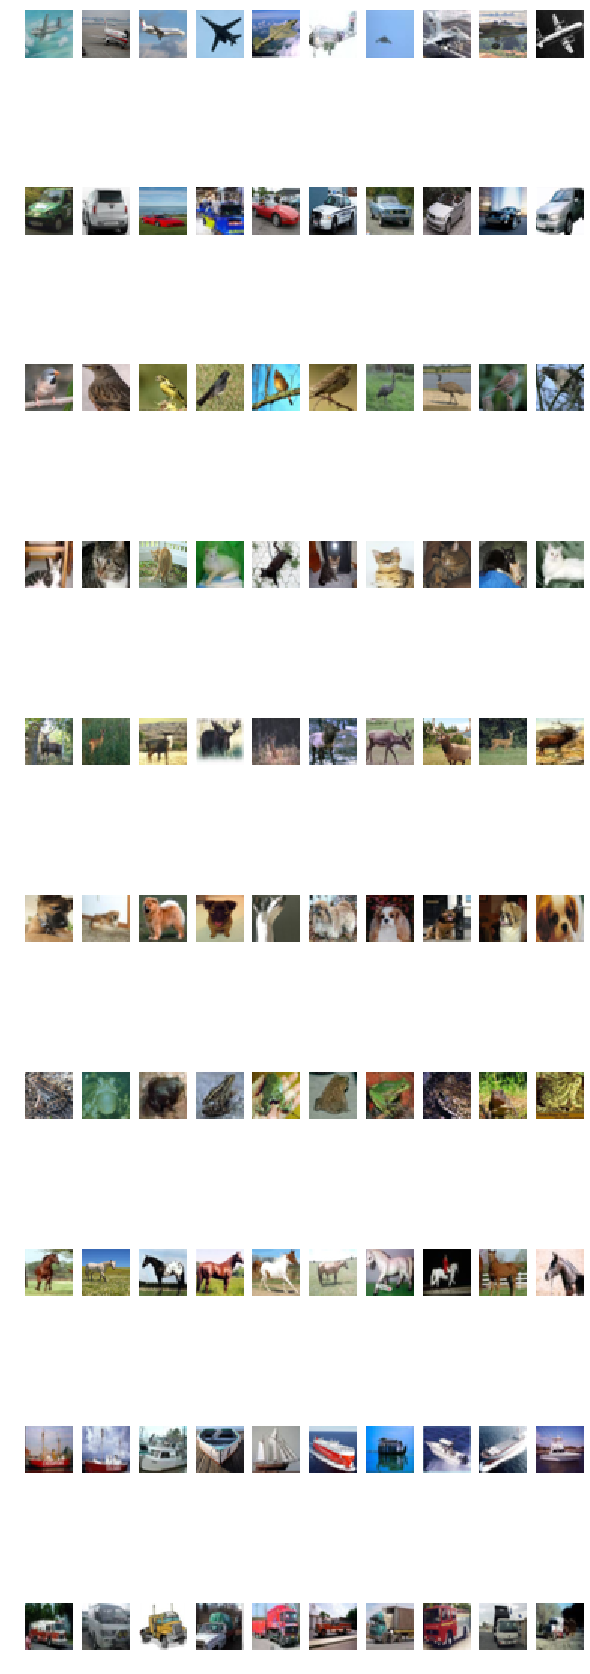

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# index = random.randint(0, len(X_train))
# image = X_train[index].squeeze()



plt.figure(figsize=(num_samples, img_width))
for c in range(n_classes):
    draw_samples(X_train, y_train, c, n_classes)
# 
# plt.imshow(image)
# plt.axis('off')
# print(y_train[index])

## Pasul 3. Definirea modelului in TensorFlow

### *Nota* Vom folosi tensoflow slim pentru a ne face viata mai usoara.

In [0]:
import tensorflow as tf

slim = tf.contrib.slim
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)


## Definirea unui argument scope. 

Un argument scope furnizeaza parametri default pentru operatiile din slim.
Pentru a consulta parametri default, ne putem uita direct in codul sursa:

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L917

In [0]:
def cifarnet_arg_scope(weight_decay=0.004, is_training=True):
  """Defines the default cifarnet argument scope.

  Args:
    weight_decay: The weight decay to use for regularizing the model.

  Returns:
    An `arg_scope` to use for the cifarnet model.
  """
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      activation_fn=tf.nn.relu):
    with slim.arg_scope(
        [slim.fully_connected],
        biases_initializer=tf.constant_initializer(0.1),
        weights_initializer=trunc_normal(0.04),
        weights_regularizer=slim.l2_regularizer(weight_decay),
        normalizer_fn=None,
        activation_fn=tf.nn.relu) as sc:
      return sc


## Task 1. Adaugati normalizare pentru conv2d folosind batchn norm si argument scope.
Hints: 
* cautati argumentul care controleaza normalizarea in definitiea conv2d din slim https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L917
* vrem sa controlam rata de invatare si pentru batchnorm.

```
batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'decay': 0.997,
      'epsilon': 0.001,
  }

```

In acest snippet de cod batch norm este configurat sa:
  * scada mean-ul
  * imparta la varianta
  * train/test e configurat prin variabila
  * momentum-ul este controlat de `decay`
  * impartirea cu 0 este previnita cu `epsilon`
  

* pentru a configura argumentele default pentr o operatie direct cu un dictionar puteti folosi apel de genul:
  `arg_scope(op_list, ** params)`

```
@tf_contextlib.contextmanager
def arg_scope(list_ops_or_scope, **kwargs):
  """Stores the default arguments for the given set of list_ops.
  For usage, please see examples at top of the file.
  Args:
    list_ops_or_scope: List or tuple of operations to set argument scope for or
      a dictionary containing the current scope. When list_ops_or_scope is a
      dict, kwargs must be empty. When list_ops_or_scope is a list or tuple,
      then every op in it need to be decorated with @add_arg_scope to work.
    **kwargs: keyword=value that will define the defaults for each op in
              list_ops. All the ops need to accept the given set of arguments.
  
```

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/framework/python/ops/arg_scope.py#L112

 

In [0]:
def cifarnet_arg_scope_bnorm(weight_decay=0.004, is_training=True):
  """Defines the batch norm cifarnet argument scope.

  Args:
    weight_decay: The weight decay to use for regularizing the model.

  Returns:
       An `arg_scope` to use for the cifarnet model.
  """
  
  batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'decay': 0.997,
      'epsilon': 0.001,
  }
  
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      activation_fn=tf.nn.relu6,
      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm], **batch_norm_params):
      with slim.arg_scope(
          [slim.fully_connected],
          biases_initializer=tf.constant_initializer(0.1),
          weights_initializer=trunc_normal(0.04),
          weights_regularizer=slim.l2_regularizer(weight_decay),

          activation_fn=tf.nn.relu) as sc:
         
          return sc


## CifarNet

In [0]:
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)

def cifarnet_bn(images, num_classes=10, is_training=False,
             dropout_keep_prob=0.5,
             prediction_fn=slim.softmax,
             scope='CifarNet'):
 
  end_points = {}

  with tf.variable_scope(scope, 'CifarNet', [images]):
    net = slim.conv2d(images, 64, [5, 5], scope='conv1')
    end_points['conv1'] = net
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool1')
    end_points['pool1'] = net
    net = slim.conv2d(net, 64, [5, 5], scope='conv2')
    end_points['conv2'] = net
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool2')
    end_points['pool2'] = net
    net = slim.flatten(net)
    end_points['Flatten'] = net
    net = slim.fully_connected(net, 384, scope='fc3')
    end_points['fc3'] = net
    net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                       scope='dropout3')
    net = slim.fully_connected(net, 192, scope='fc4')
    end_points['fc4'] = net
    if not num_classes:
      return net, end_points
    logits = slim.fully_connected(net, num_classes,
                                  biases_initializer=tf.zeros_initializer(),
                                  weights_initializer=trunc_normal(1/192.0),
                                  weights_regularizer=None,
                                  activation_fn=None,
                                  scope='logits')

    end_points['Logits'] = logits
    end_points['Predictions'] = prediction_fn(logits, scope='Predictions')

  return logits, end_points

In [0]:
# parametri de training si input
batch_size = 32
height = 32
width = 32
channels = 3
num_classes = 10
initial_learning_rate = 0.05

### Adaugarea conexiunilor de intrare. tf.placeholders

In [0]:
    def add_placeholders():


        def _process_image(augment_level, image):
            # Because these operations are not commutative, consider randomizing
            # randomize the order their operation.
            if augment_level > 0:
                image = tf.image.random_brightness(image, max_delta=30)
                image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
            if augment_level > 1:
                image = tf.image.random_saturation(image, lower=0.5, upper=1.6)
                image = tf.image.random_hue(image, max_delta=0.15)
            image = tf.minimum(image, 255.0)
            image = tf.maximum(image, 0)
            return image

        # image batch input
        image_input = tf.placeholder(
            tf.float32, [batch_size, height, width, 3],
            name='image_input'
        )

        label_input = tf.placeholder(
            tf.int64, [batch_size],
            name='label_input'
        )
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        learning_rate = tf.placeholder(tf.float32, shape=[])
        
        return image_input, label_input, is_training, learning_rate


### Nota
Pentru augmentare adaugati o operatie tensorflow in input:

```

if is_training:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), _process_image(1, image_input))
else:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), self.image_input)

scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
self.scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

```

Mai sus se opereaza folosind `_process_image` augmenatere de brgithnes si saturation.
Inainte, input-ul este normalizat.

Normalizarea se efectueaza atat la training cat si la testing.
Augmentarea se efectueaza doar la testing si are rol in generelizare.

Puteti folosi si horizontal flipping `tf.image.random_flip_left_right`

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right


In [0]:
images_train.shape

(50000, 32, 32, 3)

In [0]:
labels_train.shape

(50000, 10)

In [0]:
np.unique(cls_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Functie helper pentru a incarca un minibatch random la training

In [0]:
def random_batch(img, labels):
    # Number of images in the training-set.
    num_images = len(img)
    #     print(num_images)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = img[idx, :, :, :]
    y_batch = labels[idx]

    return x_batch, y_batch

In [22]:
x, y = random_batch(X_train, y_train)

y.shape

(32,)

### Functie helper pentru obtinirea unui batch la test. Nu facem shuffle la test

In [23]:
def get_batch(imgs, labels, step):
  offset = (step * batch_size) % (labels.shape[0] - batch_size)
#   print(offset)
  batch_imgs = imgs[offset:(offset + batch_size), :, :, :]
  batch_labels = labels[offset:(offset + batch_size)]
  
  return batch_imgs, batch_labels
  
batch_imgs, batch_labels = get_batch(images_test, cls_test, 2)
  
print(batch_imgs.shape)
print(batch_labels.shape)
  

(32, 32, 32, 3)
(32,)


### Functie pentru evaluare acuratete

In [0]:
#evaluate model



def evaluate():
  total_examples = cls_test.shape[0]  
  iters = int(total_examples/batch_size)
#   print("Total examples {}".format(total_examples))
#   print("Total iters {}".format(iters))
  
  
  acc = []
  losses = []
    
  for i in range(iters):
    
    x, y = get_batch(images_test, cls_test, i)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    acc.append(testAcc)
    losses.append(testLoss)
    #if i % 100 == 0:
    #  print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
    
      
#   print(acc)
  meanAcc = np.mean(np.asarray(acc))
  meanLoss = np.mean(np.asarray(losses))
  
#   print("Test Accuracy {:.2f} %".format(meanAcc * 100))
  
  return meanAcc, meanLoss
  
  
#evaluate()               


In [0]:
trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []
learningRateList = []

### Definirea pasilor de antrenare

In [26]:

num_steps = 50000
num_examples = images_train.shape[0]
iters = num_examples / batch_size
learning_rate_step = 20000
learning_rate_decay = 0.1

tf.reset_default_graph()

g = tf.Graph().as_default()
image_input, label_input, is_training, learning_rate = add_placeholders()
arg_scope = cifarnet_arg_scope_bnorm(is_training=is_training)
with slim.arg_scope(arg_scope):
  logits, end_points = cifarnet_bn(image_input, is_training=is_training)

loss = tf.reduce_mean(
  tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_input, logits=logits))

# accuracy of the trained model, between 0 (worst) and 1 (best)
predictions = end_points['Predictions']

correct_prediction = tf.equal(tf.argmax(predictions, 1), label_input)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


init = tf.global_variables_initializer()


sess = tf.Session()
# actually initialize our variables
sess.run(init)



# Optimizer.
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# for batch norm training. Note: we should use slim.train_op

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
  # Ensures that we execute the update_ops before performing the train_step
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
  

  
running_lr = initial_learning_rate

print("Starting optimization")
print("Initial LR {}. LR stepdown itnerval {}. LR deacy factor {}".format(running_lr, learning_rate_step, learning_rate_decay))

for i in range(num_steps):
  x, y = random_batch(X_train, y_train)

  feed_dict = {

      image_input: x,
      label_input: y,
      is_training: True,
      learning_rate : running_lr

  }

  if i % 200 == 0:
      _, trainAcc, trainLoss = sess.run([optimizer, accuracy, loss], feed_dict=feed_dict)
      
      testAcc, testLoss = evaluate()
      
      print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
      print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
      
      trainingAccuracyList.append(trainAcc)
      trainingLossList.append(trainLoss)
      testAccuracyList.append(testAcc)
      testLossList.append(testLoss)
      learningRateList.append(running_lr)
     
  else:
      sess.run([optimizer], feed_dict=feed_dict)
  
  
  if  i > 0 and i % learning_rate_step == 0:
      print("Learning reate step down. Old {}. New {}".format(running_lr, running_lr * learning_rate_decay))
      running_lr = running_lr * learning_rate_decay
      
          
    




      

Starting optimization
Initial LR 0.05. LR stepdown itnerval 20000. LR deacy factor 0.1
Train 0: accuracy:0.0625 loss: 2.2957473
Test 0: accuracy:0.11608574 loss: 2.3073175
Train 200: accuracy:0.375 loss: 1.8754079
Test 200: accuracy:0.16786858 loss: 2.2552521
Train 400: accuracy:0.46875 loss: 1.5596766
Test 400: accuracy:0.153746 loss: 2.4377272
Train 600: accuracy:0.375 loss: 1.5978096
Test 600: accuracy:0.18529648 loss: 2.4790502
Train 800: accuracy:0.46875 loss: 1.601486
Test 800: accuracy:0.24909855 loss: 2.1513245
Train 1000: accuracy:0.375 loss: 1.780682
Test 1000: accuracy:0.2797476 loss: 2.323271
Train 1200: accuracy:0.5625 loss: 1.126972
Test 1200: accuracy:0.38581732 loss: 1.7702869
Train 1400: accuracy:0.53125 loss: 1.403656
Test 1400: accuracy:0.4398037 loss: 1.501294
Train 1600: accuracy:0.4375 loss: 1.5442363
Test 1600: accuracy:0.33153045 loss: 2.1412349
Train 1800: accuracy:0.46875 loss: 1.4769365
Test 1800: accuracy:0.49859777 loss: 1.4253998
Train 2000: accuracy:0.562

Train 9000: accuracy:0.6875 loss: 0.93301755
Test 9000: accuracy:0.6411258 loss: 1.0647956
Train 9200: accuracy:0.78125 loss: 0.6354679
Test 9200: accuracy:0.61758816 loss: 1.152916
Train 9400: accuracy:0.65625 loss: 1.187495
Test 9400: accuracy:0.63571715 loss: 1.157873
Train 9600: accuracy:0.78125 loss: 0.68909013
Test 9600: accuracy:0.6665665 loss: 0.990878
Train 9800: accuracy:0.84375 loss: 0.5260645
Test 9800: accuracy:0.70332533 loss: 0.8514885
Train 10000: accuracy:0.71875 loss: 0.65071726
Test 10000: accuracy:0.67217547 loss: 0.95807964
Train 10200: accuracy:0.84375 loss: 0.6524108
Test 10200: accuracy:0.6837941 loss: 0.92855346
Train 10400: accuracy:0.78125 loss: 0.44069472
Test 10400: accuracy:0.7067308 loss: 0.84168714
Train 10600: accuracy:0.6875 loss: 1.0083747
Test 10600: accuracy:0.6869992 loss: 0.89179796
Train 10800: accuracy:0.71875 loss: 0.67573416
Test 10800: accuracy:0.67578125 loss: 0.99996305
Train 11000: accuracy:0.6875 loss: 0.767582
Test 11000: accuracy:0.6768

Train 18000: accuracy:0.9375 loss: 0.3160746
Test 18000: accuracy:0.7441907 loss: 0.75790066
Train 18200: accuracy:0.8125 loss: 0.46620506
Test 18200: accuracy:0.7375801 loss: 0.8091475
Train 18400: accuracy:0.9375 loss: 0.29826123
Test 18400: accuracy:0.75871396 loss: 0.71798396
Train 18600: accuracy:0.84375 loss: 0.7683929
Test 18600: accuracy:0.7428886 loss: 0.77373034
Train 18800: accuracy:0.875 loss: 0.44956744
Test 18800: accuracy:0.7462941 loss: 0.79285586
Train 19000: accuracy:0.75 loss: 0.5607511
Test 19000: accuracy:0.70542866 loss: 0.91772264
Train 19200: accuracy:0.78125 loss: 0.5313944
Test 19200: accuracy:0.72886616 loss: 0.8413802
Train 19400: accuracy:0.84375 loss: 0.44504225
Test 19400: accuracy:0.724359 loss: 0.8684282
Train 19600: accuracy:0.9375 loss: 0.15720817
Test 19600: accuracy:0.7322716 loss: 0.85651064
Train 19800: accuracy:0.8125 loss: 0.38826138
Test 19800: accuracy:0.7207532 loss: 0.90588146
Train 20000: accuracy:0.75 loss: 0.479333
Test 20000: accuracy:0.

KeyboardInterrupt: ignored

### Plotting

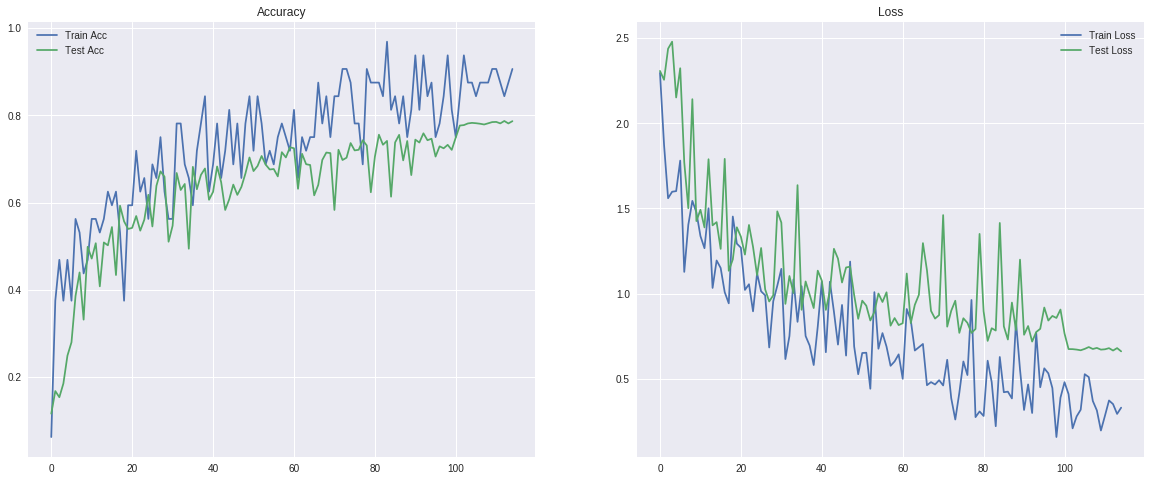

In [27]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Train Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

## Evaluate final model

In [28]:

  
acc, test_loss = evaluate()

print("Test accuracy:" + str(acc) + " loss: " + str(test_loss))
                   

Test accuracy:0.78625804 loss: 0.66461086


### Nota

* Fara batch norm: accuracy 73 %
* Cu batch norm: accuracy ~ 78 %

## Save a model checkpoint. Restoring a model checkpoint

In [29]:
# Save / restore model

#!mkdir ckpts

vars_to_save = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_save)


model_name ='./ckpts/cifarnet-batchnorm.ckpt'
saver.save(sess, model_name, global_step=num_steps)
print(vars_to_save)

[<tf.Variable 'CifarNet/conv1/weights:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/weights:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'CifarNet/fc3/weights:0' shape=(4096, 384) dtype=float32_ref>, <tf.Variable 'CifarNet/fc3/biases:0' shape=(384,) dtype=float32_ref>, <tf.Variable 'CifarNet

## Exmplu calcul acuratete folosint tf.metrics

`tf.metrics.accuracy` 

```
labels = ...
predictions = ...
accuracy, update_op_acc = tf.metrics.accuracy(
    labels, predictions)
error, update_op_error = tf.metrics.mean_absolute_error(
    labels, predictions)

sess.run(tf.local_variables_initializer())
for batch in range(num_batches):
  sess.run([update_op_acc, update_op_error])

accuracy, mean_absolute_error = sess.run([accuracy, mean_absolute_error])

```

https://www.tensorflow.org/api_docs/python/tf/metrics


## Testing model restore works

In [30]:
# test restore works
evaluate()
sess.run(init)
evaluate()
vars_to_restore = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_restore)
model_to_restore = "{}-{}".format(model_name, num_steps)
saver.restore(sess, model_to_restore)
evaluate()

INFO:tensorflow:Restoring parameters from ./ckpts/cifarnet-batchnorm.ckpt-50000


(0.78625804, 0.66461086)

In [0]:
#!ls ./ckpts

### One hot encoding

In [31]:
x, y = get_batch(images_test, cls_test, i)

y = y[:4]
print(y)
print(num_classes)

res = tf.one_hot(indices=y, depth=num_classes)
print(sess.run(res))

[3 3 3 8]
10
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### Masurarea performantelor retelei folosind tf.metrics

In [32]:
# Remember

# predictions = end_points['Predictions']
# correct_prediction = tf.equal(tf.argmax(predictions, 1), label_input)
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# adaugam on nod pentru one hot

labels = tf.one_hot(indices=label_input, depth=num_classes)
# accuracy_streamed, update_op_acc = tf.contrib.metrics.streaming_accuracy(label_input, tf.argmax(predictions, 1))

accuracy_streamed, update_op_acc = tf.metrics.accuracy(label_input, tf.argmax(predictions, 1))

# init = tf.global_variables_initializer()
sess.run(tf.local_variables_initializer())
  

vars_to_restore = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_restore)
saver.restore(sess, model_to_restore)

evaluate()


INFO:tensorflow:Restoring parameters from ./ckpts/cifarnet-batchnorm.ckpt-50000


(0.78625804, 0.66461086)

In [33]:



def evaluate_streaming():
  total_examples = cls_test.shape[0]
  num_batches = int(total_examples / batch_size)
  print("Total examples {}".format(total_examples))
  print("Total iters {}".format(num_batches))
  
  for i in range(num_batches):
    
    x, y = get_batch(images_test, cls_test, i)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    #testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    
    if i % 10 == 0:
      _, test_acc = sess.run([update_op_acc, accuracy_streamed],  feed_dict=feed_dict)
      print("Test " + str(i) + ": accuracy:" + str(test_acc))
    
    else:
      sess.run([update_op_acc], feed_dict=feed_dict)
    
      
  test_acc = sess.run(accuracy_streamed)
  print("Mean Accuracy  {:.2f} %".format(test_acc * 100))
  
  
evaluate_streaming()

Total examples 10000
Total iters 312
Test 0: accuracy:0.0
Test 10: accuracy:0.803125
Test 20: accuracy:0.7984375
Test 30: accuracy:0.7875
Test 40: accuracy:0.7875
Test 50: accuracy:0.790625
Test 60: accuracy:0.79010415
Test 70: accuracy:0.78080356
Test 80: accuracy:0.7792969
Test 90: accuracy:0.77916664
Test 100: accuracy:0.7821875
Test 110: accuracy:0.7818182
Test 120: accuracy:0.7841146
Test 130: accuracy:0.7858173
Test 140: accuracy:0.7892857
Test 150: accuracy:0.78833336
Test 160: accuracy:0.79003906
Test 170: accuracy:0.78878677
Test 180: accuracy:0.7899306
Test 190: accuracy:0.7878289
Test 200: accuracy:0.7871875
Test 210: accuracy:0.78720236
Test 220: accuracy:0.78451705
Test 230: accuracy:0.7849185
Test 240: accuracy:0.7846354
Test 250: accuracy:0.78475
Test 260: accuracy:0.78497595
Test 270: accuracy:0.7847222
Test 280: accuracy:0.78459823
Test 290: accuracy:0.7851293
Test 300: accuracy:0.7860417
Test 310: accuracy:0.78629035
Mean Accuracy  78.63 %


## Task (pentru acasa). Masurati acuratetea modelului pe clasa

## Variabile locale vs Variabile globale

In [0]:
tf.local_variables()

In [0]:
tf.global_variables()

In [0]:
!ls ckpts

# Vizualizarea Activarilor din retea

In [34]:
# visualize endpoints
end_points


{'Flatten': <tf.Tensor 'CifarNet/Flatten/flatten/Reshape:0' shape=(32, 4096) dtype=float32>,
 'Logits': <tf.Tensor 'CifarNet/logits/BiasAdd:0' shape=(32, 10) dtype=float32>,
 'Predictions': <tf.Tensor 'CifarNet/Predictions/Reshape_1:0' shape=(32, 10) dtype=float32>,
 'conv1': <tf.Tensor 'CifarNet/conv1/Relu6:0' shape=(32, 32, 32, 64) dtype=float32>,
 'conv2': <tf.Tensor 'CifarNet/conv2/Relu6:0' shape=(32, 16, 16, 64) dtype=float32>,
 'fc3': <tf.Tensor 'CifarNet/fc3/Relu:0' shape=(32, 384) dtype=float32>,
 'fc4': <tf.Tensor 'CifarNet/fc4/Relu:0' shape=(32, 192) dtype=float32>,
 'pool1': <tf.Tensor 'CifarNet/pool1/MaxPool:0' shape=(32, 16, 16, 64) dtype=float32>,
 'pool2': <tf.Tensor 'CifarNet/pool2/MaxPool:0' shape=(32, 8, 8, 64) dtype=float32>}

In [0]:
def plotActivations(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        ax = plt.gca()
        ax.grid(False)
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [0]:
conv1 = end_points['conv1']

x, y = random_batch(X_train, y_train)

feed_dict = {

      image_input: x,
      label_input: y,
      is_training: False

  }

conv1_fmaps = sess.run(conv1, feed_dict=feed_dict)
conv1_fmaps.shape
activ1 = conv1_fmaps[0, :, :, :]




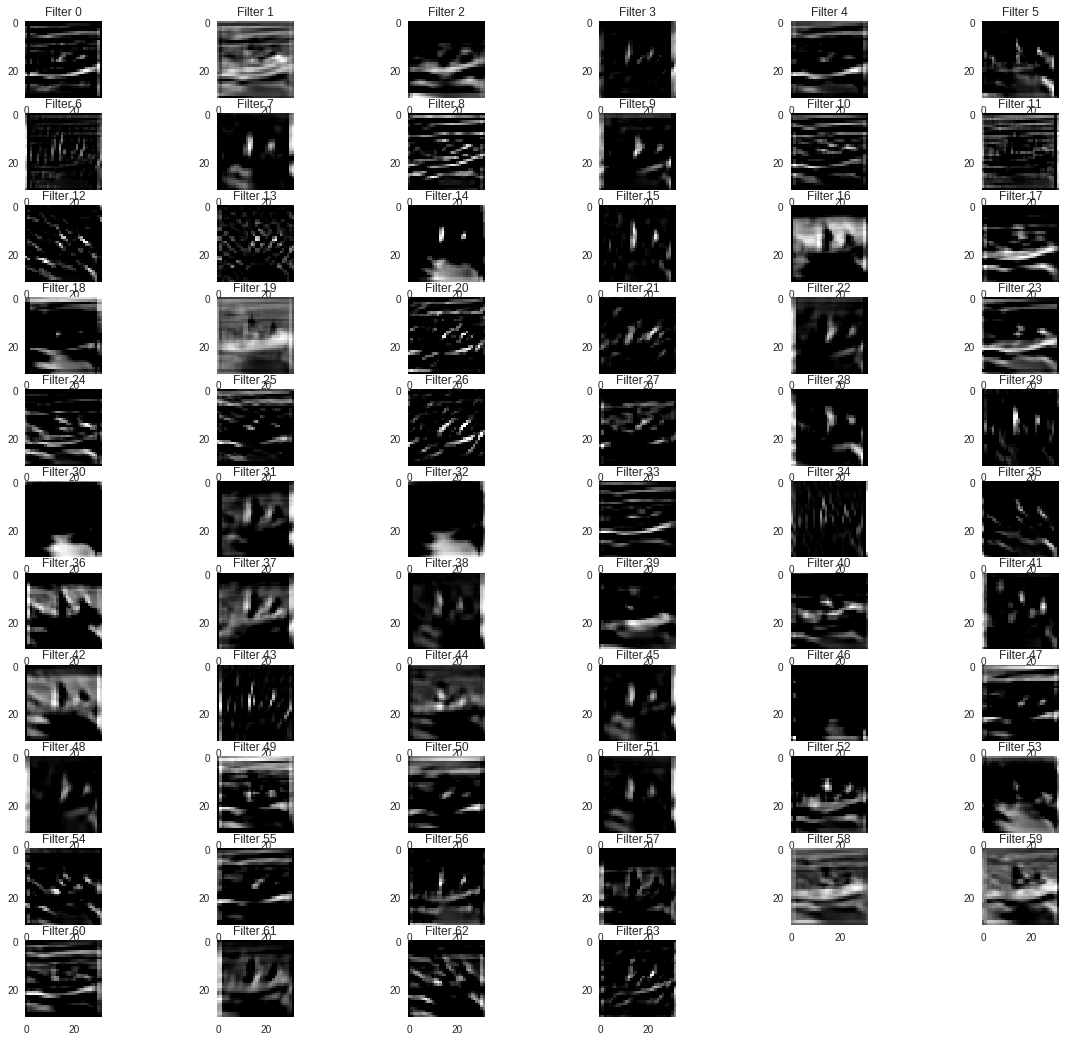

In [37]:
plotActivations(conv1_fmaps)

## Next Steps

### In clasa

1. Modificati parametri convolutiilor si dense (fully connected), * pastrand constanta arhitectura retelei* (doar din argument_scope diferit)
   Aveti in vedere:
    * Tipul de activare (relu, tanh)
    * Adaugati regularizare, normalizare batchnorm
    * optional input preprocessing
    * Adaugati batch norm si trageti concluzii

2. Observati layer-ele de MaxPooling2D. Ce fac aceste layere? Cu ce puteti inlocui layer-ul maxpool2d pastrand efectul pe dimensiuni?
  
Trageti concluzii in baza observatiilor.
Hints:
  * learning-rate-ul poate fi modificat
  * poate fi schimbat optimizatorul
  * lasati la antrenat cam 30 - 90 de epoci. Eu am antrenat 100K iteratii cu batch size 32. Pentru 50k imagini de train, inseamna 60 epoci.
  * Cu batch norm veti osberva diferenta in training.





### Acasa

** (10 p) ** 


1. Feel free sa experimentati pe CIFAR-10 cu:
  * arhitecturi imbunatatite 
  * data normalization
  * data augmentation
  * target-ul de performanta este > 78 %.
  
2. Masurarea acuratetii pe clasa.
3. Afisati top-3 probabilitati Sotfmax pentru 5 imagini impreauna cu clasa corespunzatoare. Puteti folosi matplotlib pentru a afisa probaiblitatile sub forma de barchart

Nota:

Pentru augmentare puteti folosi codul deja existent mai sus in functia ` def _process_image(augment_level, image)`. Aadaugati o operatie tensorflow in input:

```

if is_training:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), _process_image(1, image_input))
else:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), self.image_input)

scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
self.scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

```

Mai sus se opereaza folosind `_process_image` augmenatere de brightnes si saturation.
Inainte, input-ul este normalizat.


Normalizarea se efectueaza atat la training cat si la testing.
Augmentarea se efectueaza doar la testing si are rol in generelizare.

Puteti folosi si horizontal flipping `tf.image.random_flip_left_right`

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right




** Bonus **

### Project: Build a Traffic Sign Recognition Program ###

Dataset-ul CIFAR-10 are clasele balansate si doar 10 clase.
Dataset-ul German Traffic Signs are clasele nebalansate. Astfel va beneficia mai mult de data augmentation.

Mai multe detalii gasiti la:

https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb
https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project


### Pasi pentru proiect ###
1. Descracati dataset-ul
https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
2. Clonati proiectul
git clone https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

3. Urmariti pasii din notebook
cd CarND-Traffic-Sign-Classifier-Project
Launch the Jupyter notebook: jupyter notebook Traffic_Sign_Classifier.ipynb

4. Acuratetea target este > 93 %

Hint: Puteti incepe cu LeNet ca baseline.






